# <a id='toc1_'></a>[**Biomedical image segmentation with PyTorch and U-Net**](#toc0_)


## <a id='toc1_1_'></a>[Introduction](#toc0_)

Imagine you work for a hospital's radiology department. The hospital recently acquired a large dataset of MRI scans to detect brain tumors, and the current manual segmentation process is both time-consuming and prone to variability between analysts. This inconsistency can lead to delays and errors in diagnosis, affecting patient care.

To address this issue, you decide to implement a deep learning-based solution for automated image segmentation. By leveraging the power of PyTorch and the U-Net architecture, you aim to develop a model that can accurately and efficiently segment medical images, providing consistent and reliable results. This not only speeds up the diagnostic process but also reduces the workload on medical professionals, allowing them to focus on critical aspects of patient care.

In this project, you'll launch on a journey to build and train a U-Net model for biomedical image segmentation. By the end of this tutorial, you'll have a robust understanding of how to preprocess biomedical images, construct a U-Net model, and train it to achieve high accuracy in segmenting medical images, thus showcasing the transformative potential of deep learning in medical diagnostics.


## <a id='toc1_3_'></a>[Background](#toc0_)

### <a id='toc1_3_1_'></a>[What is image segmentation](#toc0_)

Image segmentation is a fundamental technique in computer vision that involves dividing a digital image into multiple segments or sets of pixels, often referred to as superpixels. The objective is to simplify the image to make it easier to analyze by transforming it into something that is more meaningful and easier to interpret.

**Types of Image Segmentation**

- **Semantic Segmentation**: Assigns a label to every pixel in an image such that pixels with the same label share certain characteristics. All pixels that belong to a specific object (like a road, car, or tree) are assigned the same label.

- **Instance Segmentation**: Goes a step beyond semantic segmentation by not only assigning each pixel a label but also distinguishing between different instances of the same type of object. For instance, it can differentiate between two cars of the same model in an image.

- **Panoptic Segmentation**: Merges the concepts of semantic and instance segmentation, classifying all pixels into a known category and differentiating between individual instances of the same category.

### <a id='toc1_3_2_'></a>[What is PyTorch](#toc0_)

[PyTorch](https://pytorch.org/) is an open-source machine learning library, developed by Facebook's AI Research lab (FAIR). It is primarily used for applications in areas such as computer vision and natural language processing.

**Common uses of PyTorch**

- **Developing deep learning models**: From standard feed-forward networks to complex neural networks like CNNs and RNNs.
- **Research and experimentation**: Facilitates rapid prototyping, which is highly valued in academic and research settings.
- **Production deployment**: With the support of TorchServe, PyTorch models can be easily transitioned from research to production environments.


### <a id='toc1_3_3_'></a>[What is U-Net](#toc0_)

**U-Net** is a fully convolutional neural network originally designed for semantic image segmentation of biomedical images. This network features a distinctive encoder-decoder structure, making it exceptionally effective for detailed and precise image analysis tasks in the medical field. Since its inception, U-Net has been widely recognized for its robust performance in segmenting complex anatomical structures in medical scans, such as MRIs and CT images.

The architecture of U-Net is particularly notable for its ability to capture contextual information at various scales, which is crucial for accurate segmentation. The encoder part of the network progressively reduces the spatial dimension of the image, capturing high-level semantic information. Conversely, the decoder part gradually recovers object details and spatial dimensions, ensuring precise localization.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Kk-yKGkvRtkNzLkZdP3Pag/unet.png" width="70%" alt="indexing"/>

**Reference:**
1. Original Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)



## <a id='toc1_4_'></a>[Objectives](#toc0_)

After you complete the project, you will:

- **Understand the basics of biomedical image segmentation**: Learn the importance and applications of image segmentation in the medical field.
- **Construct a U-Net model using PyTorch**: Learn to build a U-Net architecture using PyTorch's convolutional, max-pooling, and upsampling layers.
- **Train and evaluate your model for accurate segmentation**: Develop the ability to train your model and assess its performance in automating image segmentation tasks.


### <a id='toc1_5_1_'></a>[Installing required libraries](#toc0_)


In [1]:
!pip install numpy==1.26.4
!pip install pandas==2.2.2
!pip install matplotlib==3.9.0
!pip install opencv-python-headless==4.10.0.82
!pip install torch==2.3.1
!pip install torchvision==0.18.1

### <a id='toc1_5_2_'></a>[Importing required libraries](#toc0_)


In [2]:
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')


### <a id='toc1_5_3_'></a>[Import data](#toc0_)

The dataset used here originates from the [2012 ISBI challenge](https://imagej.net/events/isbi-2012-segmentation-challenge), specifically designed for the segmentation of neuronal structures within electron microscopic stacks. 

**Training Data**

The training data is a set of 30 sections from a serial section Transmission Electron Microscopy (ssTEM) dataset of the Drosophila first instar larva ventral nerve cord (VNC). The microcube measures 2 x 2 x 1.5 microns approx., with a resolution of 4x4x50 nm/pixel.

The corresponding binary labels are provided in an in-out fashion, i.e. white for the pixels of segmented objects and black for the rest of pixels (which correspond mostly to membranes).


In [3]:
# Define the link to the ZIP file
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o_kRuP_Bk_Pa2xvo1ly63w/data.zip'


def normalize(image):
    """
        Normalize the image to be in range 0 to 1

        Args:
            image: The input image
        Returns:
            The normalized image
    """
    return np.array(image) / 255.0


def center_crop(img, output_size):
    """
        Crop the image from the center
        
        Args:
            img: The input image
            output_size: The size of the output image
        Returns:
            The cropped image
    """
    img = np.array(img)

    start_y = (img.shape[0] - output_size[0]) // 2
    start_x = (img.shape[1] - output_size[1]) // 2

    cropped_img = img[start_y:start_y + output_size[0], start_x:start_x + output_size[1]]
    return cropped_img


def shape_process(img, input_size):
    """
    Resize the image if its height is odd and pad it to match the input size.
    
    Args:
        img (numpy array): The input image.
        input_size (tuple): The desired size of the output image as a tuple (height, width).
        
    Returns:
        numpy array: The processed image with the specified input size.
    """
    if img.shape[0] % 2:
        img = cv.resize(img, img.shape[0] // 2, interpolation=cv.INTER_CUBIC)
    padd = int((input_size[0] - img.shape[0]) / 2)
    img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)

    return img


# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Initialize lists to hold images and labels
test_images = []
train_labels = []
train_images = []

with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
    sorted_files = sorted(zip_ref.namelist())
    for file_name in sorted_files:
        if file_name.endswith('.tif'):
            with zip_ref.open(file_name) as file:
                img = Image.open(file).convert('L')  # Convert to grayscale
                img = np.array(img)
                if '/train/images/' in file_name:
                    train_images.append(normalize(shape_process(img, (572, 572))))
                elif '/train/labels/' in file_name:
                    cropped_img = center_crop(img, (388, 388))
                    normalized_img = normalize(cropped_img)
                    mask = (normalized_img > 0.5).astype(int)
                    train_labels.append(mask)
                elif '/test/' in file_name:
                    test_images.append(normalize(shape_process(img, (572, 572))))

    train_images = np.asarray(train_images, dtype=np.float32)
    # [N, H, W, C]
    train_images = train_images[:, :, :, np.newaxis]

    test_images = np.asarray(test_images, dtype=np.float32)
    test_images = test_images[:, :, :, np.newaxis]

    train_labels = np.asarray(train_labels, dtype=np.float32)
    train_labels = train_labels[:, :, :, np.newaxis]

Now, let's check the shape of: `train_images`, `train_labels`, and `test_images`.


In [4]:
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')

train_images.shape: (30, 572, 572, 1)
train_labels.shape: (30, 388, 388, 1)
test_images.shape: (30, 572, 572, 1)


Now, let's check some sample images.


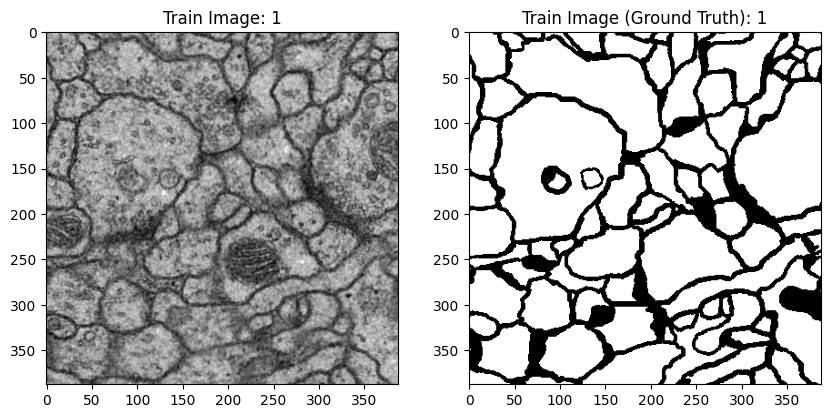

In [5]:
# Please try different index here, e.g. 1, 2, 3, ..., 29.
sample_image_index = 1

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()


+ Left Image: This is one of the training images from the dataset. It shows a high-resolution transmission electron microscopy (TEM) image of the Drosophila first instar larva ventral nerve cord (VNC). The detailed structures visible in the image represent the cellular and subcellular components of the neuronal tissue.
+ Right Image: This is the ground truth annotation corresponding to the left image. It is a binary mask, where:
  + White areas represent the segmented objects, which in this context are the neuronal structures.
  + Black areas represent the rest of the pixels, primarily corresponding to cell membranes and other non-neuronal structures.


### <a id='toc1_5_4_'></a>[U-Net architecture](#toc0_)

U-Net is renowned for its symmetric encoder-decoder structure, which is pivotal for effective image segmentation, particularly in medical imaging. This architecture enables the model to process images through a series of transformations, balancing both high and low-resolution information throughout the network.

#### <a id='toc1_5_4_1_'></a>[Encoder (Contracting path)](#toc0_)

- **Downsampling**: The encoder part of the network uses convolutional blocks to downsample the image. Each block typically consists of:
  - **Convolutional Layers**: Apply filters to extract features.
  - **Non-linear Activation Layers**: Typically ReLU (Rectified Linear Unit) to introduce non-linearities into the model, enhancing its ability to learn complex patterns.
  - **Max-Pooling Layers**: Reduce the spatial dimensions of the feature maps, increasing the field of view of the filters and thus focusing on the most prominent features.

#### <a id='toc1_5_4_2_'></a>[Decoder (Expanding path)](#toc0_)

- **Upsampling**: The decoder uses transposed convolutions to symmetrically upsample the downsampled feature map to reconstruct a high-resolution feature map that approaches the size of the original image.
- **Concatenation**: One of the distinctive features of U-Net is the concatenation of high-resolution feature maps from the contracting path with the corresponding upsampled feature maps from the expanding path. This step is crucial as it combines contextual information gathered during downsampling with the spatial information recovered during upsampling, allowing for precise localization and detailed segmentation.

#### <a id='toc1_5_4_3_'></a>[Output layer](#toc0_)

- **Convolutional Output**: Instead of using fully connected layers, U-Net employs a final convolutional layer to output the segmentation map. Each filter in this layer correlates with a specific object class, enabling the network to segment multiple classes within an image simultaneously.

#### <a id='toc1_5_4_4_'></a>[Advantages of U-Net architecture](#toc0_)

- **Efficient Use of Data**: By leveraging feature concatenation, the network effectively uses both the high-resolution features and the abstracted low-resolution context, which is especially beneficial in scenarios with limited data availability.
- **Flexibility**: The use of convolutional output layers instead of fully connected layers not only reduces the number of trainable parameters, but also enhances the network’s ability to handle images of varying sizes.

This architecture has set a standard in medical image segmentation tasks, proving particularly effective in scenarios requiring precise localization and detailed contextual understanding of the images.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Kk-yKGkvRtkNzLkZdP3Pag/unet.png" width="70%" alt="indexing"/>


In [6]:
from torch import nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.conv1 = self.double_conv(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = self.double_conv(512, 1024)

        # Upsampling path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1 
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1 
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # concat conv3 + up_conv2
        self.conv7 = self.double_conv(256 + 256, 256)

        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # concat conv2 + up_conv3
        self.conv8 = self.double_conv(128 + 128, 128)

        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # concat conv1 + up_conv4
        self.conv9 = self.double_conv(64 + 64, 64)

        self.conv10 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, source_tensor, target_shape):
        start_y = (source_tensor.shape[2] - target_shape[2]) // 2
        start_x = (source_tensor.shape[3] - target_shape[3]) // 2

        return source_tensor[:, :, start_y:start_y + target_shape[2], start_x:start_x + target_shape[3]]

    def forward(self, x):
        # Downsampling path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        x = self.conv5(p4)

        x = self.up_conv1(x)
        x = torch.cat((self.center_crop(c4, x.shape), x), dim=1)
        x = self.conv6(x)

        x = self.up_conv2(x)
        x = torch.cat((self.center_crop(c3, x.shape), x), dim=1)
        x = self.conv7(x)

        x = self.up_conv3(x)
        x = torch.cat((self.center_crop(c2, x.shape), x), dim=1)
        x = self.conv8(x)

        x = self.up_conv4(x)
        x = torch.cat((self.center_crop(c1, x.shape), x), dim=1)
        x = self.conv9(x)

        output = torch.sigmoid(self.conv10(x))

        return output

### <a id='toc1_5_5_'></a>[Display the U-Net model structure](#toc0_)

To understand the internal architecture of our U-Net model, we can visualize its configuration by printing it. This will display the layers, their order, and configurations, providing insights into how data flows through the network. The following cell executes this visualization:


In [7]:
model = UNet()
print(model)

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

**Setting up the computation device**

To optimize the performance of our neural network, it's crucial to use the available hardware acceleration. The following code checks if a CUDA-capable GPU (Graphics Processing Unit) is available. If a GPU is available, it sets the device to 'cuda' to enable GPU acceleration with PyTorch. Otherwise, it falls back to using the CPU (Central Processing Unit). 


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


**Inspecting layer output sizes in the U-Net model**

Understanding the dimensions of data as it propagates through the different layers of a neural network is crucial for debugging and optimizing the model architecture. This part of the notebook demonstrates how to programmatically inspect the output sizes of each layer in our U-Net model. 

Here's what each part of the code does:

1. **Creates a random input tensor**. 

2. **Defines a hook function**:
+ A hook function in PyTorch can be used to perform actions during the forward or backward pass.
+ This function prints the name of the module and the size of its output.

3. **Registers the hook**:
+ For each layer, it registers the print_size function as a forward hook using register_forward_hook.
+ This ensures that print_size will be called during the forward pass of each layer, printing the output size.

4. **Performs a forward pass without gradient computation**:
+ The torch.no_grad() context manager is used to disable gradient calculation, which reduces memory usage and speeds up computations during inference.
+ The input tensor is passed through the model, and the final output is computed and stored in the variable output.
+ During this forward pass, the print_size hook function will be called for each layer, printing the output size at each step.

5. **Prints the final output size**:

This procedure is particularly useful for verifying the expected transformations at each stage of the model, ensuring that all layers are correctly configured and that the input dimensions are suitable for the network architecture.


In [9]:
input_tensor = torch.randn(1, 1, 572, 572)


def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")


for layer in model.children():
    layer.register_forward_hook(print_size)


with torch.no_grad():
    output = model(input_tensor)

print("Final output size:", output.size())

Sequential output size: torch.Size([1, 64, 568, 568])
MaxPool2d output size: torch.Size([1, 64, 284, 284])
Sequential output size: torch.Size([1, 128, 280, 280])
MaxPool2d output size: torch.Size([1, 128, 140, 140])
Sequential output size: torch.Size([1, 256, 136, 136])
MaxPool2d output size: torch.Size([1, 256, 68, 68])
Sequential output size: torch.Size([1, 512, 64, 64])
MaxPool2d output size: torch.Size([1, 512, 32, 32])
Sequential output size: torch.Size([1, 1024, 28, 28])
ConvTranspose2d output size: torch.Size([1, 512, 56, 56])
Sequential output size: torch.Size([1, 512, 52, 52])
ConvTranspose2d output size: torch.Size([1, 256, 104, 104])
Sequential output size: torch.Size([1, 256, 100, 100])
ConvTranspose2d output size: torch.Size([1, 128, 200, 200])
Sequential output size: torch.Size([1, 128, 196, 196])
ConvTranspose2d output size: torch.Size([1, 64, 392, 392])
Sequential output size: torch.Size([1, 64, 388, 388])
Conv2d output size: torch.Size([1, 1, 388, 388])
Final output si

**Creating data loaders for training**

In PyTorch, data loaders are an essential component that simplify data manipulation for training and testing machine learning models. They handle batching, shuffling, and loading the data during the training process, which is vital for efficiency and effectiveness. Below, we will detail the steps involved in preparing these loaders for training dataset.


In [10]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Create data loaders
batch_size = 1

# Create tensors for the first 6 images (3 for training, 3 for validation)
train_tensor = torch.from_numpy(train_images[:6]).permute(0, 3, 1, 2).float().to(device)
train_groundtruth_tensor = torch.from_numpy(train_labels[:6]).permute(0, 3, 1, 2).float().to(device)

dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

# Set seed for reproducibility
torch.manual_seed(42)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### <a id='toc1_5_6_'></a>[Training the U-Net model](#toc0_)

The code below outlines the process of setting up and executing the training loop.

1. **Model setup**:
   - `model = UNet().to(device)`: Initializes the U-Net model and moves it to the appropriate device (CPU or GPU), which is determined by the `device` variable. 

2. **Optimizer**:
   - `optim = torch.optim.Adam(model.parameters(), lr=0.0001)`: Sets up the Adam optimizer for the model with a learning rate of 0.0001.

3. **Training epochs**:
   - `epochs = 5`: Specifies that the model should be trained over 5 epochs. An epoch is a complete pass over the entire training dataset.

**Note**: The following code just shows how to configure the training with a few epochs and images. For comprehensive training, typically 300 epochs and all 30 images from the dataset would be used. We will also provide a pre-trained model for you to use later.

Please note that this training session may take **6~7 minutes** to complete. Please be patient.


In [11]:
from tqdm.notebook import tqdm

model = UNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 5

train_losses = []
val_losses = []

# Training and validation loop
for e in tqdm(range(epochs), leave=False, desc="Epoch"):
    model.train()
    epoch_train_loss = 0  # To accumulate loss for each epoch

    for data, labels in tqdm(train_dl, leave=False, desc="   Training Dataset"):
        optim.zero_grad()
        prediction = model(data)
        loss = F.mse_loss(prediction, labels)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()  # Summing up the loss for the epoch

    average_train_loss = epoch_train_loss / len(train_dl)
    train_losses.append(average_train_loss)

    # Validation step
    model.eval()
    epoch_val_loss = 0  # To accumulate loss for validation
    with torch.no_grad():
        for data, labels in tqdm(val_dl, leave=False, desc="   Validation Dataset"):
            prediction = model(data)
            loss = F.mse_loss(prediction, labels)
            epoch_val_loss += loss.item()  # Summing up the loss for the epoch

    average_val_loss = epoch_val_loss / len(val_dl)
    val_losses.append(average_val_loss)

    print(f"Epoch {e+1}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.2435, Val Loss: 0.2398


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.2390, Val Loss: 0.2351


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.2344, Val Loss: 0.2294


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.2281, Val Loss: 0.2210


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.2187, Val Loss: 0.2065


Then we will visualize the model's performance by plotting the loss curve.


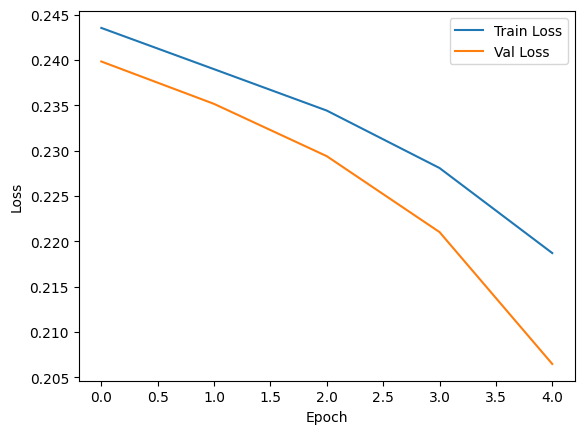

In [12]:
# Plot the loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

As evident from the epoch-wise loss data, there is a **decrease** in loss values.


### <a id='toc1_5_7_'></a>[Loading and testing a pre-trained U-Net model](#toc0_)

To demonstrate the application of a pre-trained U-Net model, we will perform image segmentation on a sample test image. This example uses a model that has been trained previously and stored remotely. We will load this model and use it for inference to highlight the model's capabilities, particularly in processing biomedical images. Since we're using the CPU for this example, the process is more for demonstration rather than optimized performance, which would typically require a GPU.


In [13]:
def download_pt_file(url):
    response = requests.get(url)
    return io.BytesIO(response.content)


pt_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Iu482aowoEaP9MgNqhyJ_w/model-epo300.pt'
state_dict = torch.load(download_pt_file(pt_file_url), map_location=torch.device(device))

model = UNet().to(device)
model.load_state_dict(state_dict)
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

Since we do not have ground truth for the testing data, we will visualize the predictions on the training data and compare them with the ground truth.


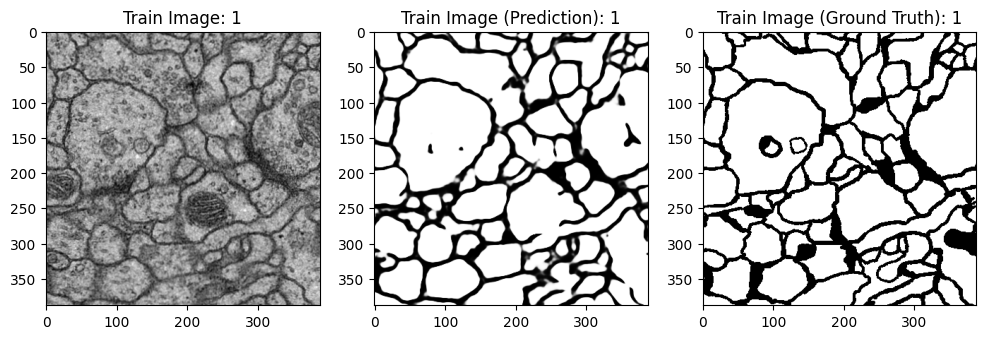

In [14]:
# Try different sample_image_index here.
sample_image_index = 1

predictions = []
test_tensor = torch.from_numpy(train_images[sample_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 3, 2)
plt.imshow(make_grid(prediction)[0].numpy(), cmap='gray')
plt.title(f'Train Image (Prediction): {sample_image_index}')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()

It is evident that the prediction closely resembles the ground truth. 

Now, let us try some test images.


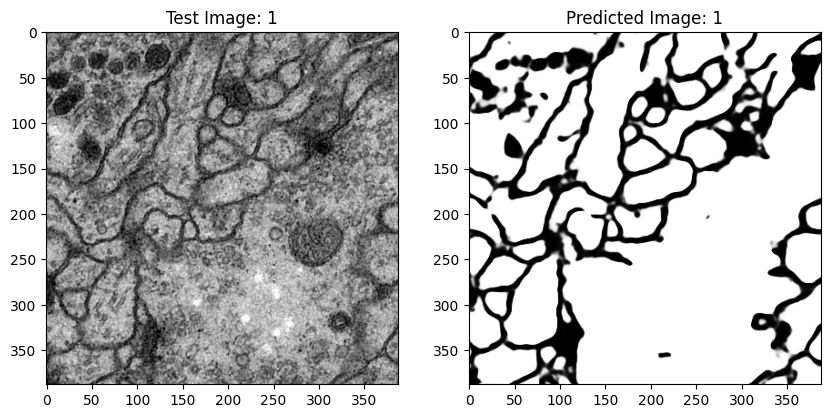

In [15]:
test_image_index = 1

predictions = []
test_tensor = torch.from_numpy(test_images[test_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(test_images[test_image_index], (388, 388))), cmap='gray')
plt.title(f'Test Image: {test_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(make_grid(prediction)[0].numpy(), cmap='gray')
plt.title(f'Predicted Image: {test_image_index}')
plt.show()

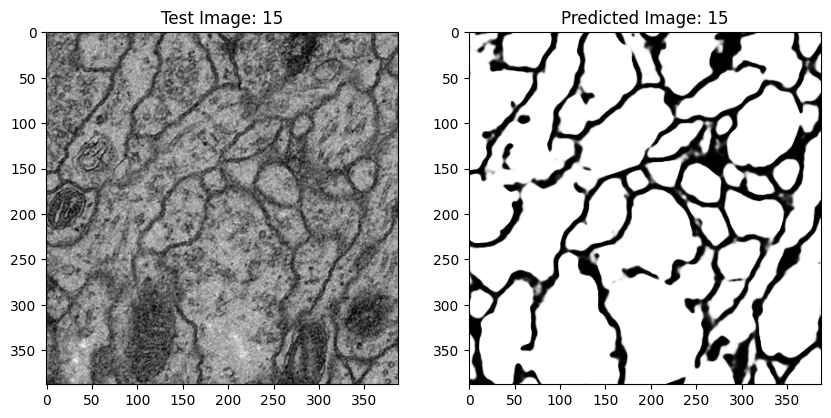

In [16]:
# Change the image_index here.
test_image_index = 15 # Change this to any number between 0 and 29

predictions = []
test_tensor = torch.from_numpy(test_images[test_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(test_images[test_image_index], (388, 388))), cmap='gray')
plt.title(f'Test Image: {test_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(make_grid(prediction)[0].numpy(), cmap='gray')
plt.title(f'Predicted Image: {test_image_index}')
plt.show()

Now, let's use another dataset: [BraTS2020 Dataset (Training + Validation)](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/data).


**Imaging Data Description**

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.


In [17]:
%pip install scikit-image==0.24.0
%pip install nibabel==5.2.1
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 81.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 50.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 24.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 33.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Extracted files: ['dataset']


Text(0.5, 1.0, 'Mask')

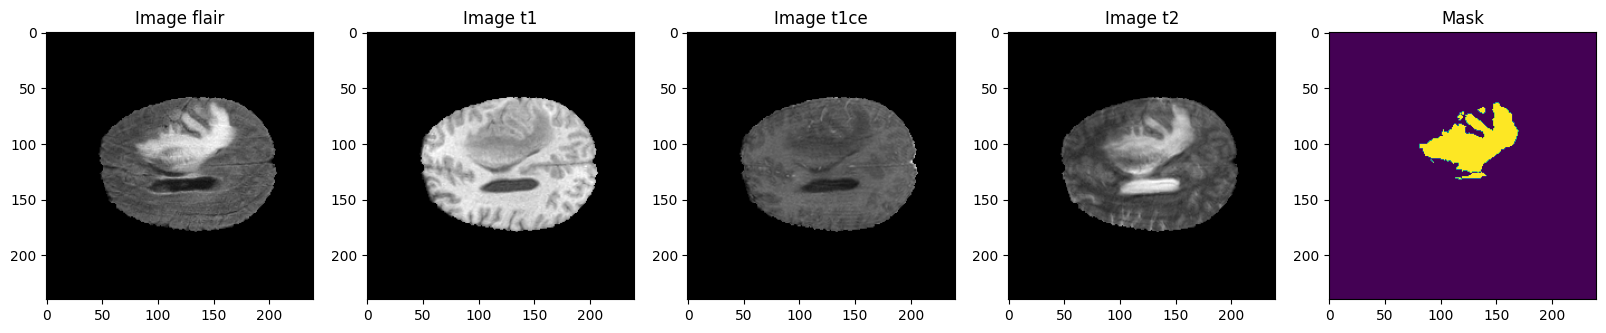

In [18]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
# from skimage.util import montage 
# import skimage.transform as skTrans
# from skimage.transform import rotate
# from skimage.transform import resize
# from PIL import Image, ImageOps  
import nibabel as nib

import requests
import zipfile
import io
import os

extract_dir = "extracted_files"
if not os.path.exists(extract_dir):
    url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/EFOEudjvmSIMYp700qwtrg/dataset.zip'

    response = requests.get(url)
    zip_file = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Extract all contents to a specific directory
        zip_ref.extractall("extracted_files")

extracted_files = os.listdir("extracted_files")
print("Extracted files:", extracted_files)

TRAIN_DATASET_PATH = 'extracted_files/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'extracted_files/dataset/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

Let's [construct](https://www.kaggle.com/code/mrmohammadi/2d-unet-pytorch/notebook) a U-Net model for the BraTS dataset.


In [19]:
import torch
import torch.nn as nn

def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return conv_op

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Expanding path
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        up_2 = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_3 = self.up_transpose_2(up_2)
        up_4 = self.up_convolution_2(torch.cat([down_5, up_3], 1))
        up_5 = self.up_transpose_3(up_4)
        up_6 = self.up_convolution_3(torch.cat([down_3, up_5], 1))
        up_7 = self.up_transpose_4(up_6)
        up_8 = self.up_convolution_4(torch.cat([down_1, up_7], 1))

        out = self.out(up_8)

        return out

Since training the model from scratch is computationally expensive, we will provide a pre-trained model for you to use.


In [20]:
model = UNet(num_classes=1)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

model.to(device)

from sklearn.model_selection import train_test_split
import os

# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.3, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.3, random_state=42)

print(f"Train: {len(train_ids)} | Validation: {len(val_ids)} | Test: {len(test_ids)}")

cpu
Train: 9 | Validation: 6 | Test: 5


In [21]:
def load_dataset(ids, path):
    images = np.zeros((len(ids)*10, 240, 240), np.float32)
    masks = np.zeros((len(ids)*10, 240, 240), np.float32)

    i = 0
    for id in ids:
        t2 = nib.load(f"{path}{id}/{id}_t2.nii").get_fdata()
        seg = nib.load(f"{path}{id}/{id}_seg.nii").get_fdata()

        for s in range(50, seg.shape[2]-50, 10):
            images[i] = t2[:, :, s] / t2.max()
            masks[i] = seg[:, :, s] > 0
            i += 1

    images = np.expand_dims(images[:i], axis=1)
    masks = np.expand_dims(masks[:i], axis=1)

    return images, masks

train_images, train_masks = load_dataset(train_ids, TRAIN_DATASET_PATH)
val_images, val_masks = load_dataset(val_ids, TRAIN_DATASET_PATH)

train_images.shape, val_masks.shape

((54, 1, 240, 240), (36, 1, 240, 240))

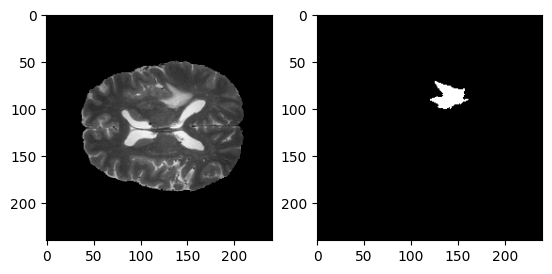

In [22]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

train_dataset = TensorDataset(torch.from_numpy(train_images).type(torch.float32), torch.from_numpy(train_masks).type(torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(val_images).type(torch.float32), torch.from_numpy(val_masks).type(torch.float32))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, Y = next(iter(train_dataloader))
plt.subplot(121)
plt.imshow(X[0, 0], cmap='gray')
plt.subplot(122)
plt.imshow(Y[0, 0], cmap='gray')

Now, we will use the pre-trained model to make predictions.

In case there are some issues with the following code due to the platform's capability, I will show the sample result here:

![results.jpg](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/wuD3axkV8qCl79ZSZE4U6g/results.jpg)


In [ ]:
import torch
import requests
import zipfile
import io
import os


checkpoint_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HATpl02lA0ykn9aAU9K6sA/checkpoint-epoch-29.pt'
local_checkpoint_path = 'checkpoint-epoch-29.pt'

if not os.path.exists(local_checkpoint_path):
    response = requests.get(checkpoint_url)
    # Save the downloaded file locally
    with open(local_checkpoint_path, 'wb') as f:
        f.write(response.content)

# Load the checkpoint
checkpoint = torch.load(local_checkpoint_path, map_location=torch.device('cpu'))

# Reinitialize the model architecture
model = UNet(num_classes=1).to(torch.device('cpu'))

# Load the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

X, y = next(iter(test_dataloader))
X, y = X.to(torch.device('cpu')), y.to(torch.device('cpu'))

with torch.inference_mode():
    y_pred = model(X)

y1 = y[3, 0].cpu().detach().numpy()
y2 = y_pred[3, 0].cpu().detach().numpy()
plt.subplot(121)
plt.imshow(y1, cmap='gray')
plt.title('Ground Truth')
plt.subplot(122)
plt.imshow(y2, cmap='gray')
plt.title('Prediction')
plt.show()


y_color = np.zeros((*y1.shape, 3))
y_color[..., 0] = y1
y_color[..., 1] = y2
y_color[..., 2] = y2


plt.subplot(121)
plt.imshow(X[4, 0].cpu().detach().numpy())
plt.subplot(122)
plt.imshow(y_color)

## <a id='toc1_7_'></a>[Authors](#toc0_)


[Ricky Shi](https://author.skills.network/instructors/ricky_shi)


## <a id='toc1_8_'></a>[Contributors](#toc0_)


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk)

[Kang Wang](https://author.skills.network/instructors/kang_wang)


Copyright © 2024 IBM Corporation. All rights reserved.
